In [57]:
from vnstock import Vnstock
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import requests

In [ ]:
from math import sqrt


def get_port_price(symbols, start_date, end_date):

    result = pd.DataFrame()


    for s in symbols:

        stock = Vnstock().stock(symbol=s, source="TCBS")

        df = stock.quote.history(start=start_date, end=end_date, interval="1D")

        if result.empty:

            result["time"] = df["time"]

        result[s] = df["close"]

    result.set_index("time", inplace=True)
    return result



def get_port(price, N=252):

    port_ret = np.log(price / price.shift(1))
    port_annual_risk = np.sqrt(port_ret.std() * sqrt(N))
    port_annual_ret = ((1 + port_ret.mean()) ** N) - 1

    sharpe_ratio = port_annual_ret / port_annual_risk
    result = pd.DataFrame(
        {
            "DailyReturn": port_ret.mean(),
            "DailyRisk": port_ret.std(),
            "AnnualReturn": port_annual_ret,
            "AnnualRisk": port_annual_risk,
            "Sharpe Ratio": sharpe_ratio,
        }
    )
    return result

In [59]:
symbols = ["ACB", "MBB", "TCB"]
price = get_port_price(symbols, "2014-01-01", "2025-01-01")

2025-03-11 12:00:13 - vnstock.explorer.tcbs.quote - ERROR - Dữ liệu không tồn tại từ 2014-01-01 đến 2014-12-31: 'time'
2025-03-11 12:00:13 - vnstock.explorer.tcbs.quote - ERROR - Dữ liệu không tồn tại từ 2015-01-01 đến 2015-12-31: 'time'
2025-03-11 12:00:14 - vnstock.explorer.tcbs.quote - ERROR - Dữ liệu không tồn tại từ 2016-01-01 đến 2016-12-31: 'time'
2025-03-11 12:00:14 - vnstock.explorer.tcbs.quote - ERROR - Dữ liệu không tồn tại từ 2017-01-01 đến 2017-12-31: 'time'


In [60]:
port = get_port(price, 252)
port

,DailyReturn,DailyRisk,AnnualReturn,AnnualRisk,Sharpe Ratio
ACB,0.000760,0.017449,0.210887,0.526304,0.400695
MBB,0.000708,0.018213,0.195249,0.537703,0.363116
TCB,0.000237,0.020864,0.061503,0.575507,0.106867


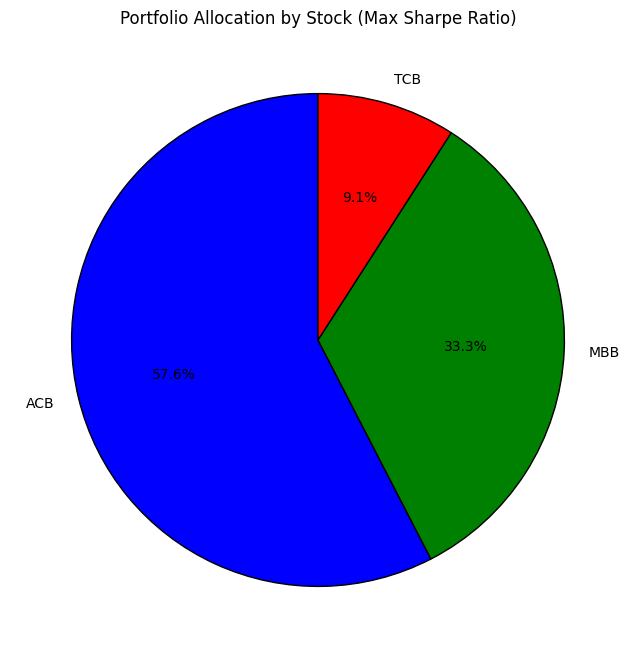

In [ ]:
def calculate_optimal_portfolio(symbols, price, port, no_of_port=10000, risk_free_rate=0.0267):
    num_stocks = len(symbols)
    weight = np.zeros((no_of_port, num_stocks))
    expected_ret = np.zeros(no_of_port)
    expected_vol = np.zeros(no_of_port)
    sharpe_ratio = np.zeros(no_of_port)

    port_ret = np.log(price / price.shift(1))

    for i in range(no_of_port):
        weight_random = np.random.random(num_stocks)
        weight_random /= np.sum(weight_random)
        weight[i, :] = weight_random
        expected_ret[i] = np.sum(port["AnnualReturn"] * weight_random)
        expected_vol[i] = np.sqrt(
            np.dot(weight_random.T, np.dot(port_ret.cov() * 252, weight_random))
        )
        sharpe_ratio[i] = (expected_ret[i] - risk_free_rate) / expected_vol[i]

    max_sharpe_index = sharpe_ratio.argmax()
    max_return_index = expected_ret.argmax()
    min_risk_index = expected_vol.argmin()

    optimal_portfolio = pd.DataFrame(
        {
            "Symbols": symbols,
            "Max Sharpe Weight": weight[max_sharpe_index, :].round(decimals=2) * 100,
            "Max Return Weight": weight[max_return_index, :].round(decimals=2) * 100,
            "Min Risk Weight": weight[min_risk_index, :].round(decimals=2) * 100,
        }
    )

    return optimal_portfolio


optimal_portfolio = calculate_optimal_portfolio(symbols, price, port)
# Create a pie chart for the portfolio weights
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    optimal_portfolio["Max Sharpe Weight"],
    labels=optimal_portfolio["Symbols"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["blue", "green", "red"],
    wedgeprops={"edgecolor": "black"},
)
ax.set_title("Portfolio Allocation by Stock (Max Sharpe Ratio)")
plt.show()

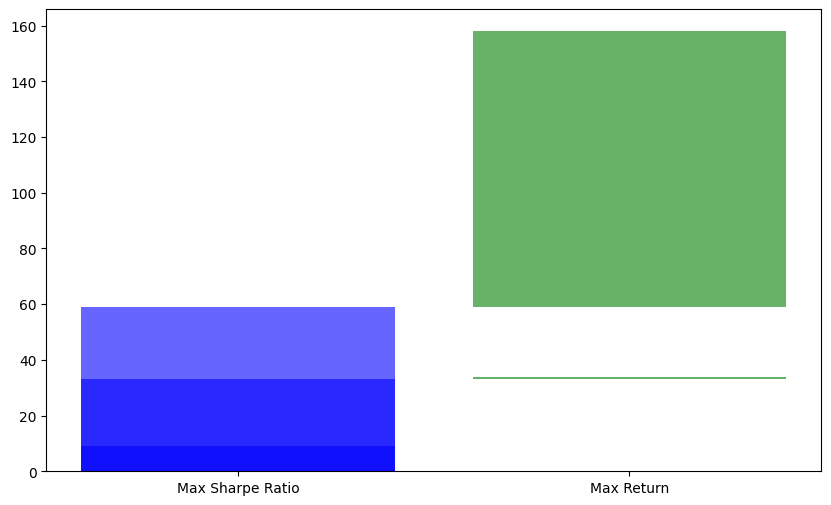

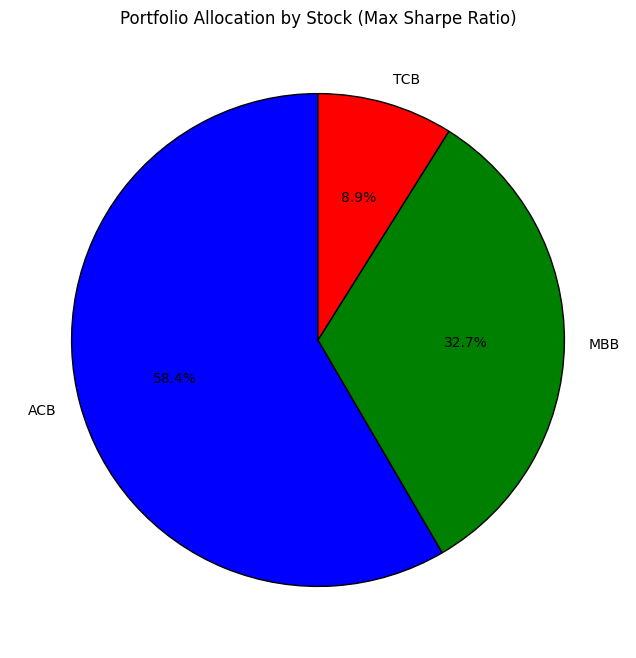

In [ ]:
def calculate_optimal_portfolio(symbols, price, port, no_of_port=10000, risk_free_rate=0.0267):
    num_stocks = len(symbols)
    weight = np.zeros((no_of_port, num_stocks))
    expected_ret = np.zeros(no_of_port)
    expected_vol = np.zeros(no_of_port)
    sharpe_ratio = np.zeros(no_of_port)

    port_ret = np.log(price / price.shift(1))

    for i in range(no_of_port):
        weight_random = np.random.random(num_stocks)
        weight_random /= np.sum(weight_random)
        weight[i, :] = weight_random
        expected_ret[i] = np.sum(port["AnnualReturn"] * weight_random)
        expected_vol[i] = np.sqrt(
            np.dot(weight_random.T, np.dot(port_ret.cov() * 252, weight_random))
        )
        sharpe_ratio[i] = (expected_ret[i] - risk_free_rate) / expected_vol[i]

    max_sharpe_index = sharpe_ratio.argmax()
    max_return_index = expected_ret.argmax()
    min_risk_index = expected_vol.argmin()

    optimal_portfolio = pd.DataFrame(
        {
            "Symbols": symbols,
            "Max Sharpe Weight": weight[max_sharpe_index, :].round(decimals=2) * 100,
            "Max Return Weight": weight[max_return_index, :].round(decimals=2) * 100,
            "Min Risk Weight": weight[min_risk_index, :].round(decimals=2) * 100,
        }
    )

    return optimal_portfolio


optimal_portfolio = calculate_optimal_portfolio(symbols, price, port)
# Plot the portfolio weights
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Max Sharpe Ratio weights
bars1 = ax.bar(
    ["Max Sharpe Ratio"] * len(optimal_portfolio["Symbols"]),
    optimal_portfolio["Max Sharpe Weight"],
    label="Max Sharpe Ratio",
    color="blue",
    alpha=0.6,
)

# Plot Max Return weights
bars2 = ax.bar(
    ["Max Return"] * len(optimal_portfolio["Symbols"]),
    optimal_portfolio["Max Return Weight"],
    label="Max Return",
    color="green",
    alpha=0.6,
    bottom=optimal_portfolio["Max Sharpe Weight"],
)

# Plot Min Risk weights
# Create a pie chart for the portfolio weights
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    optimal_portfolio["Max Sharpe Weight"],
    labels=optimal_portfolio["Symbols"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["blue", "green", "red"],
    wedgeprops={"edgecolor": "black"},
)
ax.set_title("Portfolio Allocation by Stock (Max Sharpe Ratio)")
plt.show()

# Add data labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.2f}%",
            xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

# Set labels and title
ax.set_xlabel("Loại danh mục")
ax.set_ylabel("Weight (%)")
ax.set_title("Optimal Portfolio Weights")
ax.legend(loc="upper right")

plt.show()

In [62]:
port_ret.corr()

,ACB,HPG,FPT
ACB,1.000000,0.371696,0.426565
HPG,0.371696,1.000000,0.396959
FPT,0.426565,0.396959,1.000000


In [63]:
port_ret.cov()

,ACB,HPG,FPT
ACB,0.000304,0.000133,0.000137
HPG,0.000133,0.000419,0.000149
FPT,0.000137,0.000149,0.000338


In [64]:
num_stocks = len(symbols)

In [65]:
from datetime import datetime, timedelta

headers = {
    # "X-Request-Id": id,
    "pgrade-Insecure-Requests": "1",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36 Edg/122.0.0.0",
}


def cf_analysis(stock, period):
    try:
        today = datetime.now()
        start_date = today - timedelta(days=period)
        all_data = []

        for i in range(period + 1):
            date = start_date + timedelta(days=i)
            date = date.strftime("%Y-%m-%d")
            api_url = f"https://api-finfo.vndirect.com.vn/v4/cashflow_analysis/latest?order=time&where=code:{stock}~period:30M&filter=date:{date}"
            res = requests.get(url=api_url, headers=headers)
            res.raise_for_status()
            data = res.json()
            all_data.extend(data["data"])

        df = pd.DataFrame(all_data)
        return df
    except requests.exceptions.RequestException as e:
        print("Yêu cầu không thành công:", e)
        return None

In [66]:
df = cf_analysis("HPG", 30)

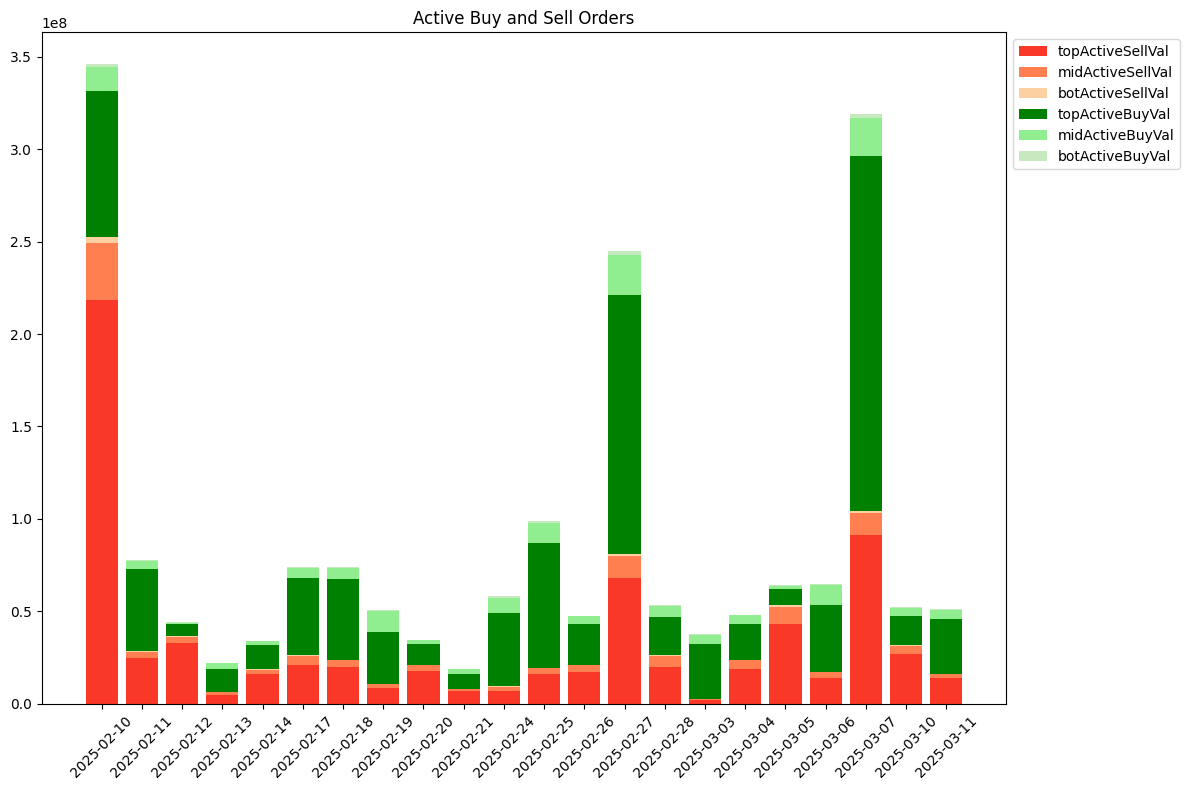

In [67]:
# Extract the relevant columns for the bar chart
buy_columns = ["topActiveBuyVal", "midActiveBuyVal", "botActiveBuyVal"]
sell_columns = ["topActiveSellVal", "midActiveSellVal", "botActiveSellVal"]
df = cf_analysis("HPG", 30)
# Create a new DataFrame for the bar chart
df_stacked = df[["date"] + buy_columns + sell_columns]

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors
buy_colors = ["green", "lightgreen", "#c7e9c0"]  # Green shades for buy orders
sell_colors = ["#F93827", "coral", "#fdd0a2"]  # Red shades for sell orders

# Plot sell orders
bottom_sell = np.zeros(len(df_stacked))
for col, color in zip(sell_columns, sell_colors):
    ax.bar(df_stacked["date"], df_stacked[col], bottom=bottom_sell, label=col, color=color)
    bottom_sell += df_stacked[col]

# Plot buy orders on top of sell orders
bottom_buy = bottom_sell.copy()
for col, color in zip(buy_columns, buy_colors):
    ax.bar(df_stacked["date"], df_stacked[col], bottom=bottom_buy, label=col, color=color)
    bottom_buy += df_stacked[col]

# Set labels and title
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Active Buy and Sell Orders")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()